<a href="https://colab.research.google.com/github/afrahhassan/afrahhassan/blob/main/assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
## Task
This report will analyse the methodology used to complete assignment 2 of the course Machine Learning (COSC2673/2793). The objective of the assignment is to develop a machine-learning system that can classify traffic sign images.

The project is divided into two tasks:


*   Classify images according to the shape of the given image.
*    Classify images according to type.



## Approach
Our goal is to be able to identify the best possible machine-learning algorithm to generate a model that can reliably and consistently predict whether the type of traffic sign is based on image recognition.

# Reading Data

In [52]:
from google.colab import drive
import os
import csv
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

In [31]:
!cp -r "/content/drive/MyDrive/Assignment2" .

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Assignment2/trafficsigns_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

create a type csv

In [108]:
root_dir = '/content/trafficsigns_dataset'
output_csv = '/content/drive/My Drive/Assignment2/type.csv'
with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_path', 'class'])

    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                full_path = os.path.join(root, file)
                class_name = os.path.basename(root)
                writer.writerow([full_path, class_name])
print("CSV file has been created successfully.")

CSV file has been created successfully.


Train type dataset

In [109]:
dataType= pd.read_csv('/content/drive/My Drive/Assignment2/type.csv')

train_data, test_data = train_test_split(dataType, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 2219, Val Data: 740, Test Data: 740


In [110]:
dataType.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3699 entries, 0 to 3698
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3699 non-null   object
 1   class       3699 non-null   object
dtypes: object(2)
memory usage: 57.9+ KB


create a type csv and encoding classes

In [111]:
output_csv = '/content/drive/My Drive/Assignment2/shape.csv'

class_mapping = {}

with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_path', 'class', 'encoded_class'])

    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                full_path = os.path.join(root, file)
                class_name = os.path.basename(os.path.dirname(root))

                if class_name not in class_mapping:
                    class_mapping[class_name] = len(class_mapping)

                writer.writerow([full_path, class_name, class_mapping[class_name]])
for class_name, encoded_class in class_mapping.items():
    print(f"Class: {class_name}, Encoded Class: {encoded_class}")

print("CSV file has been created successfully.")

Class: diamond, Encoded Class: 0
Class: hex, Encoded Class: 1
Class: triangle, Encoded Class: 2
Class: square, Encoded Class: 3
Class: round, Encoded Class: 4
CSV file has been created successfully.


Train shape dataset

In [112]:
dataShape= pd.read_csv('/content/drive/My Drive/Assignment2/shape.csv')

train_data, test_data = train_test_split(dataShape, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 2219, Val Data: 740, Test Data: 740


# EDA

# Model development

## Base Model

In [113]:
INPUT_DIM = (28, 28, 1)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 5

In [114]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'2.15.0'

In [115]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
])

In [116]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               200960    
                                                                 
 dense_11 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 202245 (790.02 KB)
Trainable params: 202245 (790.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


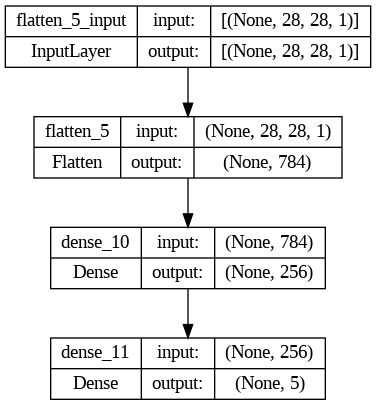

In [117]:
tf.keras.utils.plot_model(model, show_shapes=True)


In [118]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [119]:
train_data['class'] = train_data['class'].astype('str')
val_data['class'] = val_data['class'].astype('str')

In [138]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 20

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./dataShape/train',
        x_col="image_path",
        y_col="class",
        target_size=(28, 28),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./dataShape/validation',
        x_col="image_path",
        y_col="class",
        target_size=(28, 28),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical')

Found 2219 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.


In [145]:
print("Shape of training data generated by train_generator:", train_generator.image_shape)
print("Shape of validation data generated by validation_generator:", validation_generator.image_shape)


Shape of training data generated by train_generator: (28, 28, 1)
Shape of validation data generated by validation_generator: (28, 28, 1)


In [139]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [140]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=50, verbose=0)


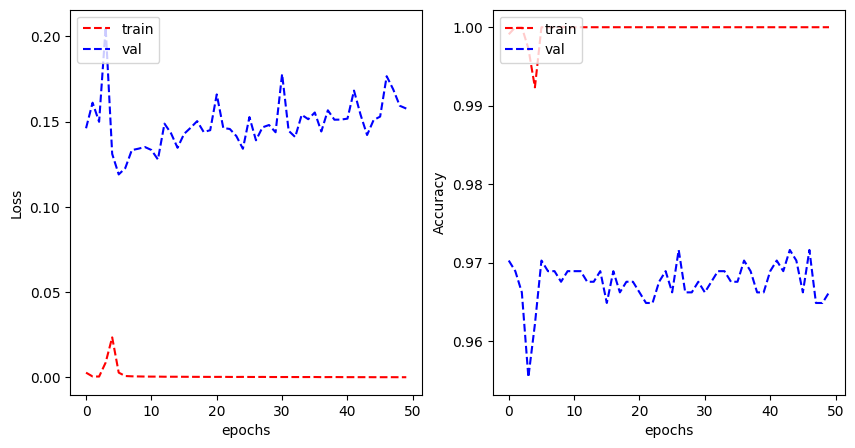

In [142]:
plot_learning_curve(history.history['loss'], history.history['val_loss'],
                    history.history['accuracy'], history.history['val_accuracy'],
                    metric_name='Accuracy')


In [161]:
test_data['class'] = test_data['class'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="image_path",
        y_col="class",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='categorical')


Found 740 validated image filenames belonging to 5 classes.


In [166]:
model.evaluate(test_generator)

InvalidArgumentError: Graph execution error:

Detected at node sequential_5/dense_10/BiasAdd defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-140-e529ab2e5327>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1856, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2296, in evaluate

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 4108, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2066, in test_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2049, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2037, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1917, in test_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/sequential.py", line 398, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py", line 252, in call

Matrix size-incompatible: In[0]: [1,3072], In[1]: [784,256]
	 [[{{node sequential_5/dense_10/BiasAdd}}]] [Op:__inference_test_function_69301]

In [167]:
label_names = {'airplane' : 0, 'automobile' : 1, 'bird' : 2, 'cat' : 3, 'deer' : 4, 'dog' : 5}

## Setup Keras locally

### Compile the model


### Set up the layers

### Train the model

In [37]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

### Incremental changes

# Testing the final model